## Test on a simple case
Consider the following Possion Equation
$$
\begin{cases}
    \Delta u = 0\qquad &u\in\Omega\\
    u(r,\theta) = \sqrt{r}sin(\frac{\theta}{2})\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = (-1,1)\times(-1,1)\backslash[0,1)\times\{0\}$

The exact solution to this problem is $$u = \sqrt{r}sin(\frac{\theta}{2}).$$

In [68]:
% matplotlib inline
import torch 
import torch.nn.functional as F
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 5 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error

#用DeepRitzNet模拟论文中的 -u
class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        self.linear7 = torch.nn.Linear(m,m)
        self.linear8 = torch.nn.Linear(m,m)
        self.linear9 = torch.nn.Linear(m,m)
        self.linear10 = torch.nn.Linear(m,m)
        
        self.linear11 = torch.nn.Linear(m,1)
    
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        y = y + F.relu(self.linear8(F.relu(self.linear7(y))))
        y = y + F.relu(self.linear10(F.relu(self.linear9(y))))
        output = F.relu(self.linear11(y))
        return output

In [56]:
def draw_graph1():
    points = np.arange(-1, 1.1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = model(re.float()).item() 
            #z[i, j] =  U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    #plt.savefig("loss_1.eps")
    plt.show()

In [59]:
def draw_graph2():
    points = np.arange(-1, 1.1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = U_groundtruth(re)
            #z[i, j] =  U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    #plt.savefig("loss_1.eps")
    plt.show()

In [60]:
def draw_graph():
    points = np.arange(-1, 1.1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = model(re.float()).item() - U_groundtruth(re)
            #z[i, j] =  U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    #plt.savefig("loss_1.eps")
    plt.show()

In [49]:
def cal_loss():
    points = np.arange(-1, 1.1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    n = 0
    for i in np.arange(1, xl):
        for j in np.arange(1, yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            #not on border
            if (i<xl/2 or j != yl/2+1):
                re = torch.tensor(re)        
                z[i, j] = (model(re.float()).item() - U_groundtruth(re))#/ U_groundtruth(re)           
                if abs(z[i, j]) > mmm:
                    mmm += abs(z[i, j])
                n += 1
    
    return mmm /n 

In [50]:
#U_groundtruth (r, theta) = sqrt(r) * sin(theta/2)
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    theta = atan2(t[1].item(), t[0].item()) #+ 2*pi #-pi < atan(·) < pi
    re = sqrt(sqrt((t[0] ** 2 + t[1] ** 2).item())) * sin(theta/2)
    return re

In [89]:
"""
Train with the grid
"""
learning_rate=0.01
model = DeepRitzNet(m)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
in_error_iter = [] #record the error in Omega every print_every_iter=100 times
on_error_iter = [] #record the error on the border of Omega every print_every_iter=100 times

mm = 1
points = np.arange(-1, 1.1, 0.1)
xs, ys = np.meshgrid(points, points)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xl, yl = xs.size()

for k in range(10000):
    loss = torch.zeros(1)
    i1=0
    for i in np.arange(1, xl):
        for j in np.arange(1, yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            
            #if (x,y)is not on x-aris
            if (abs(x_input[1]) > 0.001 or x_input[0] < 0.001): 
                x_input = torch.tensor(x_input).float()
                y = model(x_input)

                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x3 = torch.zeros(m)
                x4 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x3[0] = -0.0001
                x4[1] = -0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_3 = x_input.float() + x3
                x_input_4 = x_input.float() + x4
                x_input_grad_1 = 
                x_input_2grad_1 = (model(x_input_1) + model(x_input_3) - 2*y) / 0.0001**2
                x_input_2grad_2 = (model(x_input_2) + model(x_input_4) - 2*y) / 0.0001**2
                x_laplacian = x_input_2grad_1 + x_input_2grad_2

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) 
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                i1+=1
                
    #loss /= (xl * yl)
    loss/=i1
    
    regularization = torch.zeros(1)
    i2=0
    for i in range(xl):
        for j in range(yl): 
            if (i==0 or i==xl-1) or (j==0 or j==yl-1) or (i>=xl/2 and j==yl/2+1):
                x_input = np.zeros(m)
                x_input[0] = xs[i, j]
                x_input[1] = ys[i, j]           
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                regularization += (y.item() - U_groundtruth(x_input)) ** 2 
                i2 += 1
    #print("i1:",i1,"i2:",i2)
    regularization *= mm / i2
    #if mm < 500:
        #mm = mm * 1.01
    
    
    
    #print loss
    print(k, " epoch, loss: ", loss.item())
    print(k, " epoch, regularization loss: ", regularization.item())
    print(k, " loss to real solution: ", cal_loss())
    if cal_loss() < 0.0001:
        break
    aaa = torch.zeros(1, requires_grad = True)
    #loss = aaa + regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0  epoch, loss:  0.04886876046657562
0  epoch, regularization loss:  0.8904421925544739
0  loss to real solution:  0.0032180316849716494
1  epoch, loss:  0.0312504842877388
1  epoch, regularization loss:  0.8203656077384949
1  loss to real solution:  0.003201630535639126
2  epoch, loss:  0.01837596856057644
2  epoch, regularization loss:  0.7598544955253601
2  loss to real solution:  0.0031930792435177157
3  epoch, loss:  0.009330052882432938
3  epoch, regularization loss:  0.7045340538024902
3  loss to real solution:  0.003205951835132439
4  epoch, loss:  0.005007513798773289
4  epoch, regularization loss:  0.6755995154380798
4  loss to real solution:  0.003241529251552422
5  epoch, loss:  0.0035637610126286745
5  epoch, regularization loss:  0.6588236689567566
5  loss to real solution:  0.003284392367220719
6  epoch, loss:  0.0038408024702221155
6  epoch, regularization loss:  0.6534148454666138
6  loss to real solution:  0.003327035467243988
7  epoch, loss:  0.004890791140496731
7  

59  epoch, loss:  0.00037498079473152757
59  epoch, regularization loss:  0.5927439332008362
59  loss to real solution:  0.0029338016837008787
60  epoch, loss:  0.0003720017266459763
60  epoch, regularization loss:  0.5896074175834656
60  loss to real solution:  0.002926006103969414
61  epoch, loss:  0.0003745474969036877
61  epoch, regularization loss:  0.5874349474906921
61  loss to real solution:  0.0029197732090123483
62  epoch, loss:  0.00036521509173326194
62  epoch, regularization loss:  0.5861995220184326
62  loss to real solution:  0.002915157797849972
63  epoch, loss:  0.0002551013312768191
63  epoch, regularization loss:  0.5854731202125549
63  loss to real solution:  0.00293735933593591
64  epoch, loss:  0.0004185204452369362
64  epoch, regularization loss:  0.5873903036117554
64  loss to real solution:  0.0029566851361759496
65  epoch, loss:  0.00043811442446894944
65  epoch, regularization loss:  0.5924644470214844
65  loss to real solution:  0.002975909757531483
66  epoc

117  epoch, loss:  0.00012299987429287285
117  epoch, regularization loss:  0.648098886013031
117  loss to real solution:  0.003242180432296593
118  epoch, loss:  0.00011832060408778489
118  epoch, regularization loss:  0.6476821303367615
118  loss to real solution:  0.0032444517417915654
119  epoch, loss:  0.00011200192966498435
119  epoch, regularization loss:  0.6469026207923889
119  loss to real solution:  0.00324486644110759
120  epoch, loss:  0.00010757267591543496
120  epoch, regularization loss:  0.6461970806121826
120  loss to real solution:  0.0032438364728458713
121  epoch, loss:  9.340448741568252e-05
121  epoch, regularization loss:  0.64561927318573
121  loss to real solution:  0.0032416609778173756


KeyboardInterrupt: 

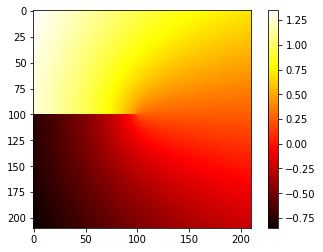

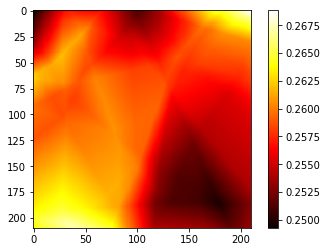

0.0032385339691408466

In [90]:
draw_graph()
draw_graph1()
cal_loss()

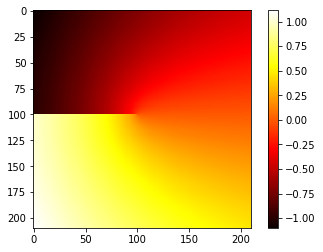

In [91]:
draw_graph2()

In [63]:
cal_loss()

0.0033051929726370167

In [33]:
learning_rate=0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

points = np.arange(-1, 1.1, 0.1)
xs, ys = np.meshgrid(points, points)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xl, yl = xs.size()

for k in range(10000):
    loss = torch.zeros(1)
    i1=0
    for i in np.arange(1, xl):
        for j in np.arange(1, yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            
            #if (x,y)is not on x-aris
            if (abs(x_input[1]) > 0.001 or x_input[0] < 0.001): 
                x_input = torch.tensor(x_input).float()
                y = model(x_input)

                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) 
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                i1+=1
                
    #loss /= (xl * yl)
    loss/=i1
    
    regularization = torch.zeros(1)
    i2=0
    for i in range(xl):
        for j in range(yl): 
            if (i==0 or i==xl-1) or (j==0 or j==yl-1) or (i>=xl/2 and j==yl/2+1):
                x_input = np.zeros(m)
                x_input[0] = xs[i, j]
                x_input[1] = ys[i, j]           
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                regularization += (y.item()-U_groundtruth(x_input))**2 
                i2 += 1
    #print("i1:",i1,"i2:",i2)
    regularization *= mm / i2
    if mm < 500:
        mm = mm * 1.05
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    print(k, " loss to real solution: ", cal_loss())
    if cal_loss() < 0.0001:
        break
    
    loss += regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0  epoch, loss:  0.0019632606
0  epoch, regularization loss:  0.6782943
0  loss to real solution:  0.002824522136814196
1  epoch, loss:  0.0018051341
1  epoch, regularization loss:  0.7121248
1  loss to real solution:  0.002836626443184216
2  epoch, loss:  0.0016590807
2  epoch, regularization loss:  0.74699616
2  loss to real solution:  0.00284466116792639
3  epoch, loss:  0.0015230457
3  epoch, regularization loss:  0.78325444
3  loss to real solution:  0.0028516237168677637
4  epoch, loss:  0.0014216512
4  epoch, regularization loss:  0.8214061
4  loss to real solution:  0.0028580342522927116
5  epoch, loss:  0.0012944404
5  epoch, regularization loss:  0.8614431
5  loss to real solution:  0.002864939115113814
6  epoch, loss:  0.0012155398
6  epoch, regularization loss:  0.9035476
6  loss to real solution:  0.0028717404521175216
7  epoch, loss:  0.0011580084
7  epoch, regularization loss:  0.94794285
7  loss to real solution:  0.0028783448702760527
8  epoch, loss:  0.0011063849
8  e

67  epoch, loss:  0.00047543633
67  epoch, regularization loss:  17.93042
67  loss to real solution:  0.002975612479365666
68  epoch, loss:  0.00045245467
68  epoch, regularization loss:  18.831696
68  loss to real solution:  0.002976781661725838
69  epoch, loss:  0.00045458117
69  epoch, regularization loss:  19.781052
69  loss to real solution:  0.0029782024501927686
70  epoch, loss:  0.00045338765
70  epoch, regularization loss:  20.780014
70  loss to real solution:  0.002979802499628861
71  epoch, loss:  0.0004482322
71  epoch, regularization loss:  21.831902
71  loss to real solution:  0.0029815477236278844
72  epoch, loss:  0.0004442514
72  epoch, regularization loss:  22.937616
72  loss to real solution:  0.002983302111841042
73  epoch, loss:  0.0004359497
73  epoch, regularization loss:  24.098494
73  loss to real solution:  0.0029849645598896335
74  epoch, loss:  0.0004335415
74  epoch, regularization loss:  25.315
74  loss to real solution:  0.0029864207758673023


KeyboardInterrupt: 

In [ ]:
# Calculate time for grid method
start = time.time()
for k in range(10):
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                
    loss /= (xl * yl)
    
    regularization = torch.zeros(1)
    for t in range(n2):
        theta = t / n2 * (2 * pi)
        x_input = np.zeros(m)
        x_input[0] = cos(theta)
        x_input[1] = sin(theta)
        x_input = torch.tensor(x_input).float()
        y = model(x_input)
        regularization += y**2 
    regularization *= mm / n2
    if mm < 500:
        mm = mm * 1.01
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    print(k, " loss to real solution: ", cal_loss())
    if cal_loss() < 0.0001:
        break
    
    loss += regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
stop = time.time()
print(stop - start)

In [ ]:
torch.save(model.state_dict(), '3/model.pkl')